# DPM & MFM Roundup

## Methods
Default parameters:
- All DPM methods default to alpha=1.0 unless otherwise specified.
- All MFM methods default to using a poisson(k) prior unless otherwise specified.

| name | description |
|--|--|
| dpm_gibbs | DPM using gibbs sampler |
| dpm_sm | DPM using split merge only |
| dpm_hybrid | DPM using hybrid (5,1) sampler |
| dpm_eb | DPM using empirical bayes updates |
| dpm_small_alpha | DPM using alpha=0.1 |
| dpm_big_alpha | DPM using alpha=10 |
| mfm_gibbs | MFM using gibbs sampler |
| mfm_sm | MFM using split merge only |
| mfm_hybrid | MFM using hybrid (5,1) sampler |
| mfm_prior_low | MFM with a poisson(k - 2) prior |
| mfm_prior_high | MFM with a poisson(k + 2) prior |

## Definitions
- NMI: Normalized Mutual Information
- Rand score: Adjusted Rand Index
- Aggregation score: measure of tendency to cluster points that should be in the same cluster together:
$$\mathbb{P}[\mathbf{z}_i = \mathbf{z}_j | \mathbf{Z}_i = \mathbf{Z}_j]$$
- Segregation score: measure of tendency to separate points that should be in different clusters:
$$\mathbb{P}[\mathbf{z}_i \neq \mathbf{z}_j | \mathbf{Z}_i \neq \mathbf{Z}_j]$$
- Oracle: clustering algorithm with perfect knowledge of model parameters (i.e. cluster means, weights, covariance) but no knowledge of individual point assignments

## Columns
|column|description|
|--|--|
| rand | Rand score of result |
| nmi | NMI score of result |
| oracle_rand | Rand score of Oracle clustering |
| oracle_nmi | NMI of Oracle clustering |
| num_clusters | Number of clusters in result |
| best_idx | Index of 'best' configuration according to least squares. Useful for loading the clustering configuration without recomputing the least squares configuration. |
| aggregation | Aggregation score |
| segregation | Segregation score |
| oracle_aggregation | Oracle aggregation score |
| oracle_segregation | Oracle segregation score |
| iterations | Number of iterations run. NOTE: runs where the number of clusters 'blew up' (>100) were terminated, and are reflected here. |
| method | Method used. See the 'methods' section. |
| d | Number of dimensions |
| p | Number of points |
| k | Number of clusters |
| r | Ratio of weights; the nth cluster has weight proportional to $r^n$. |
| id | Run ID (uuid4) |


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
COLUMNS = {
    'rand': np.float64,
    'nmi': np.float64,
    'oracle_rand': np.float64,
    'oracle_nmi': np.float64,
    'num_clusters': np.uint16,
    'best_idx': np.uint16,
    'aggregation': np.float64,
    'segregation': np.float64,
    'oracle_aggregation': np.float64,
    'oracle_segregation': np.float64,
    'iterations': np.uint16,
    'method': str,
    'd': np.uint16,
    'p': np.uint16,
    'k': np.uint16,
    'r': np.float64,
    'id': str
}

In [3]:
SCORES = ['rand', 'nmi', 'aggregation', 'segregation']

In [29]:
METHODS = {
    'mfm_prior_high': "MFM: poisson(k + 2)",
    'mfm_hybrid': "MFM: (5,1) split merge",
    'mfm_prior_low': "MFM: poisson(k - 2)",
    'mfm_gibbs': "MFM: gibbs only",
    'mfm_sm': "MFM: split merge only",
    'dpm_small_alpha': "DPM: alpha=0.1",
    'dpm_hybrid': "DPM: (5,1) split merge",
    'dpm_big_alpha': "DPM: alpha=10",
    'dpm_sm': "DPM: split merge only",
    'dpm_gibbs': "DPM: gibbs only",
    'dpm_eb': "DPM: using empirical bayes"
}

In [5]:
METHODS

{'mfm_prior_high': 'MFM: poisson(k + 2)',
 'mfm_prior_low': 'MFM: poisson(k - 2)',
 'mfm_sm': 'MFM: split merge only',
 'dpm_small_alpha': 'DPM: alpha=0.1',
 'dpm_sm': 'DPM: split merge only',
 'dpm_hybrid': 'DPM: (5,1) split merge',
 'dpm_gibbs': 'DPM: gibbs only',
 'mfm_gibbs': 'MFM: gibbs only',
 'mfm_hybrid': 'MFM: (5,1) split merge',
 'dpm_big_alpha': 'DPM: alpha=10',
 'dpm_eb': 'DPM: using empirical bayes'}

In [6]:
summary = pd.read_csv('summary.csv', dtype=COLUMNS)

In [7]:
TESTS = summary[['d', 'p', 'k', 'r']].drop_duplicates()

In [8]:
def filter(df, **kwargs):
    for k, v in kwargs.items():
        df = df[df[k] == v]
    return df

## Plots

In [9]:
def oracle_ratio(**kwargs):
    df = filter(summary, **kwargs)

    return {k: list(df[k] / df['oracle_'+ k]) for k in SCORES}

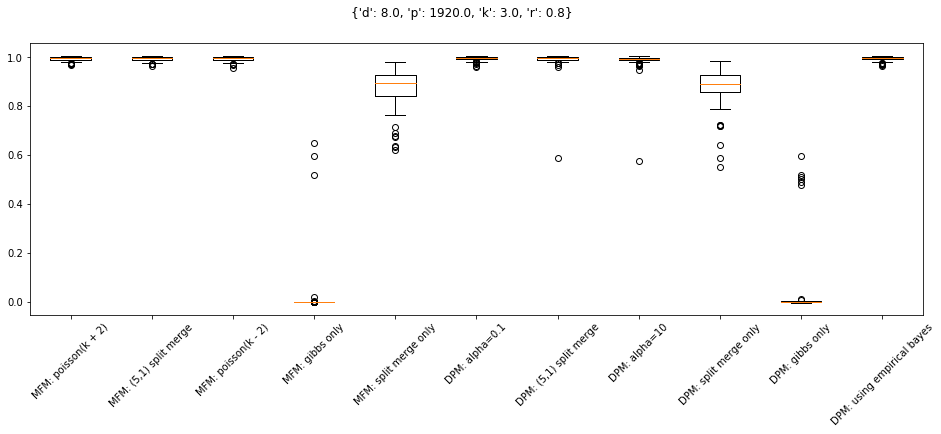

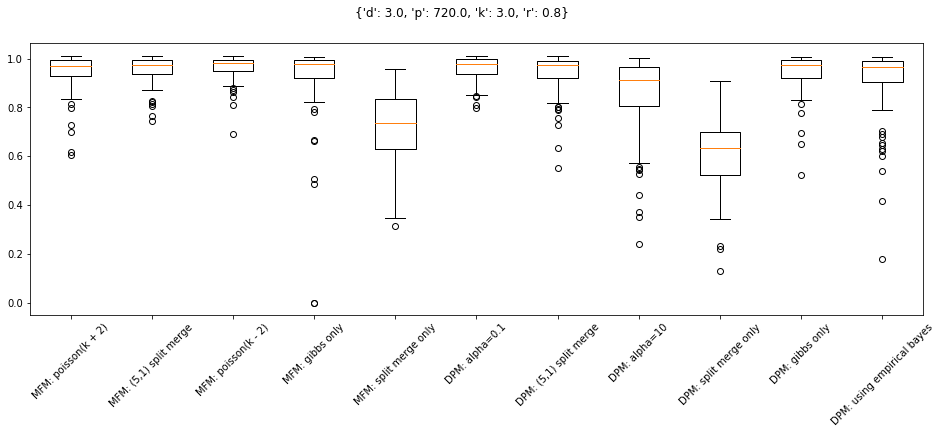

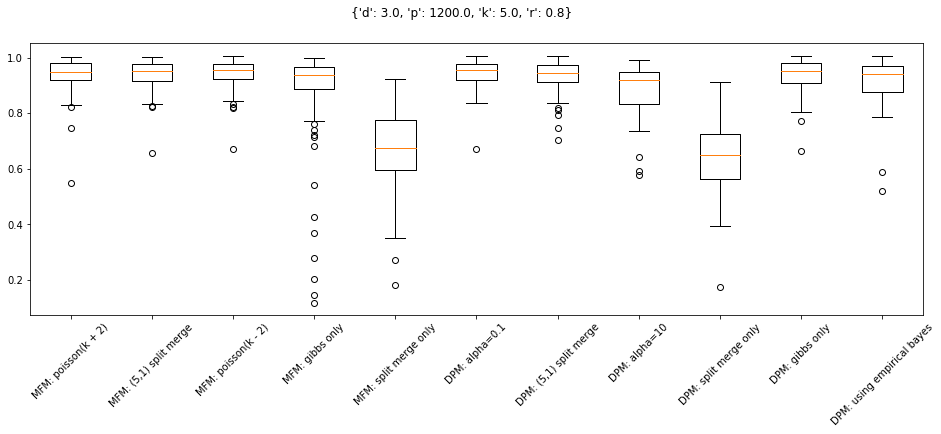

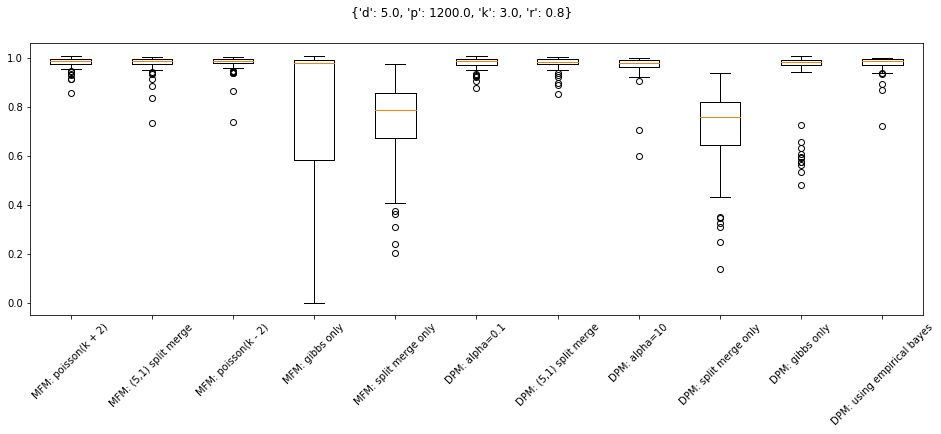

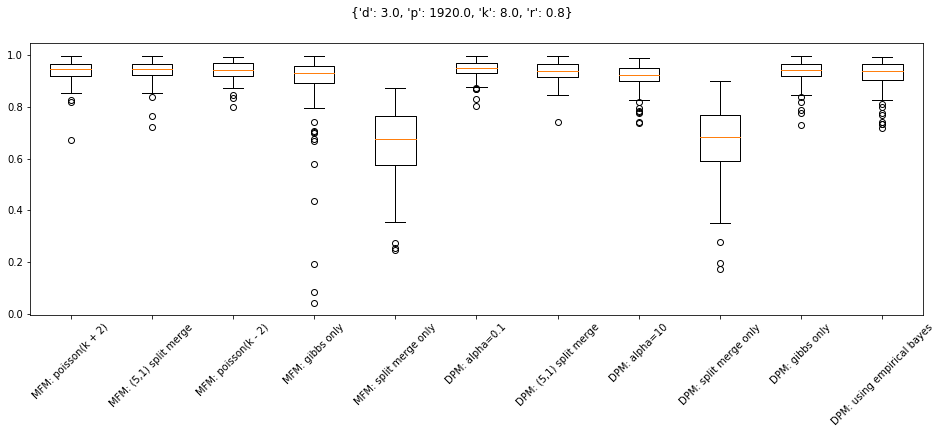

In [30]:
for i in range(5):
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    fig.suptitle(str(dict(**TESTS.iloc[i])))

    ax.boxplot([oracle_ratio(method=m, **TESTS.iloc[i])['rand'] for m in METHODS.keys()])
    ax.set_xticklabels([v for k, v in METHODS.items()], rotation=45)

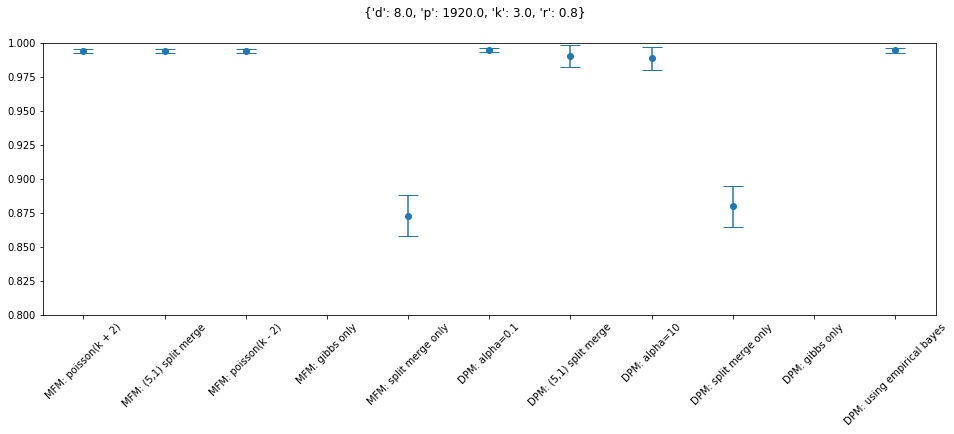

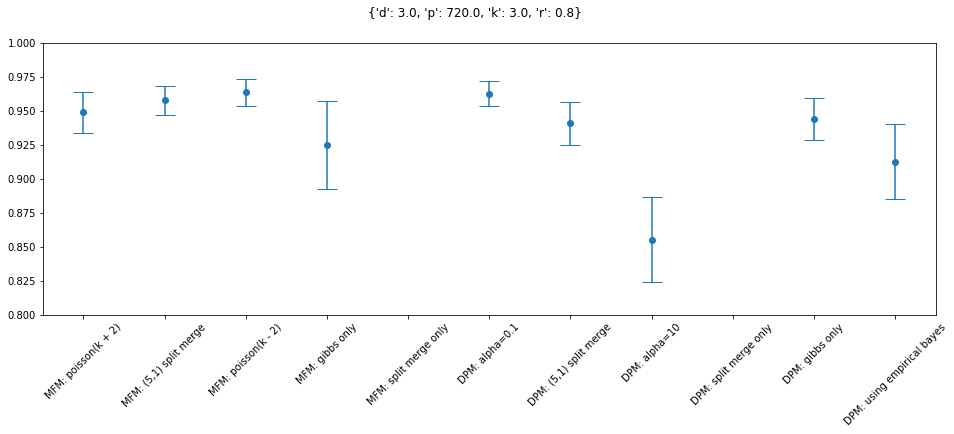

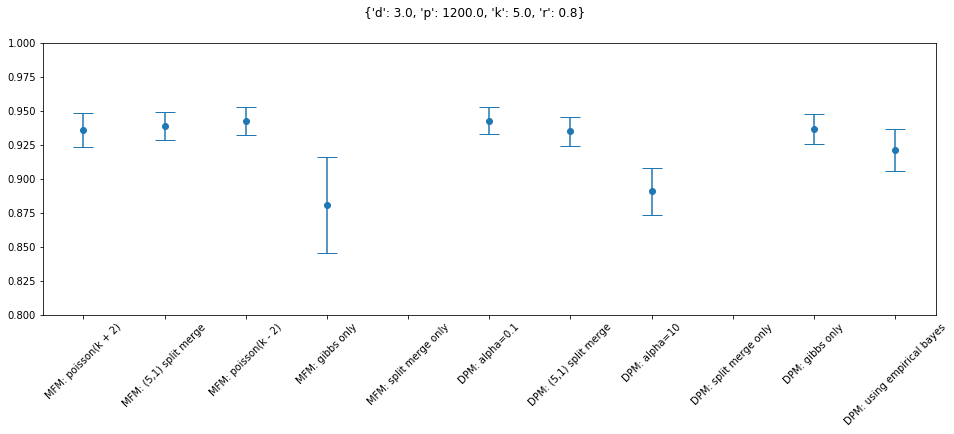

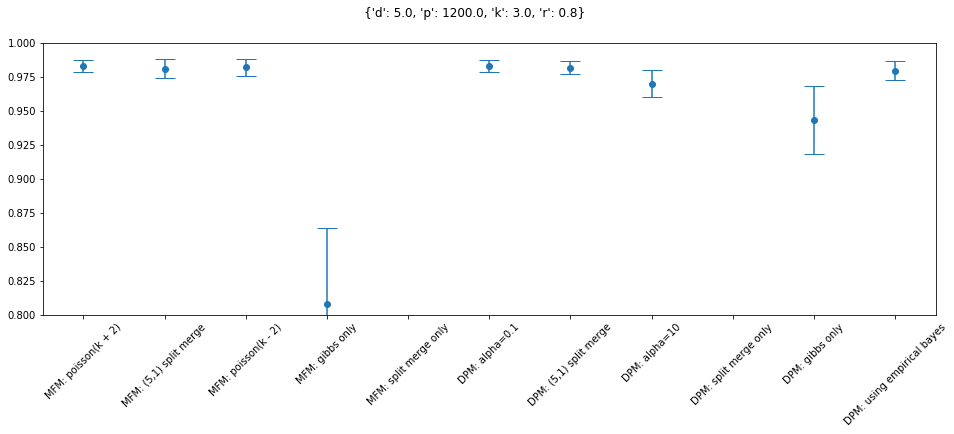

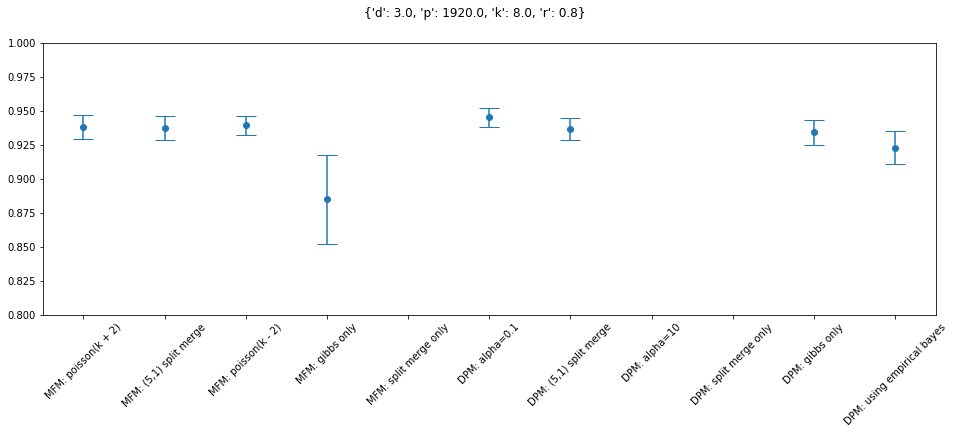

In [32]:
from scipy import stats

for i in range(5):
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    fig.suptitle(str(dict(**TESTS.iloc[i])))

    d = [oracle_ratio(method=m, **TESTS.iloc[i])['rand'] for m in METHODS.keys()]

    ax.errorbar(
        np.arange(len(METHODS)),
        [np.mean(x) for x in d],
        yerr=[stats.sem(x) * 2 for x in d],
        fmt='o',
        capsize=10)
    ax.xaxis.set_ticks(np.arange(len(METHODS)))
    ax.set_ylim(0.8, 1)
    ax.set_xticklabels([v for k, v in METHODS.items()], rotation=45)

In [ ]:
tmp = filter(summary, method="dpm_big_alpha", **TESTS.iloc[4])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(tmp['oracle_rand'], tmp['rand'])
m = min(min(tmp['oracle_rand']), min(tmp['rand']))
ax.plot((m, 1), (m, 1), c='orange')

In [ ]:
df= filter(summary, method='dpm_big_alpha', **TESTS.iloc[4])
df[df['nmi'] == 0]